# Retrieval

Retrieval is the centerpiece of our retrieval augmented generation (RAG) flow. 

Let's get our vectorDB from before.

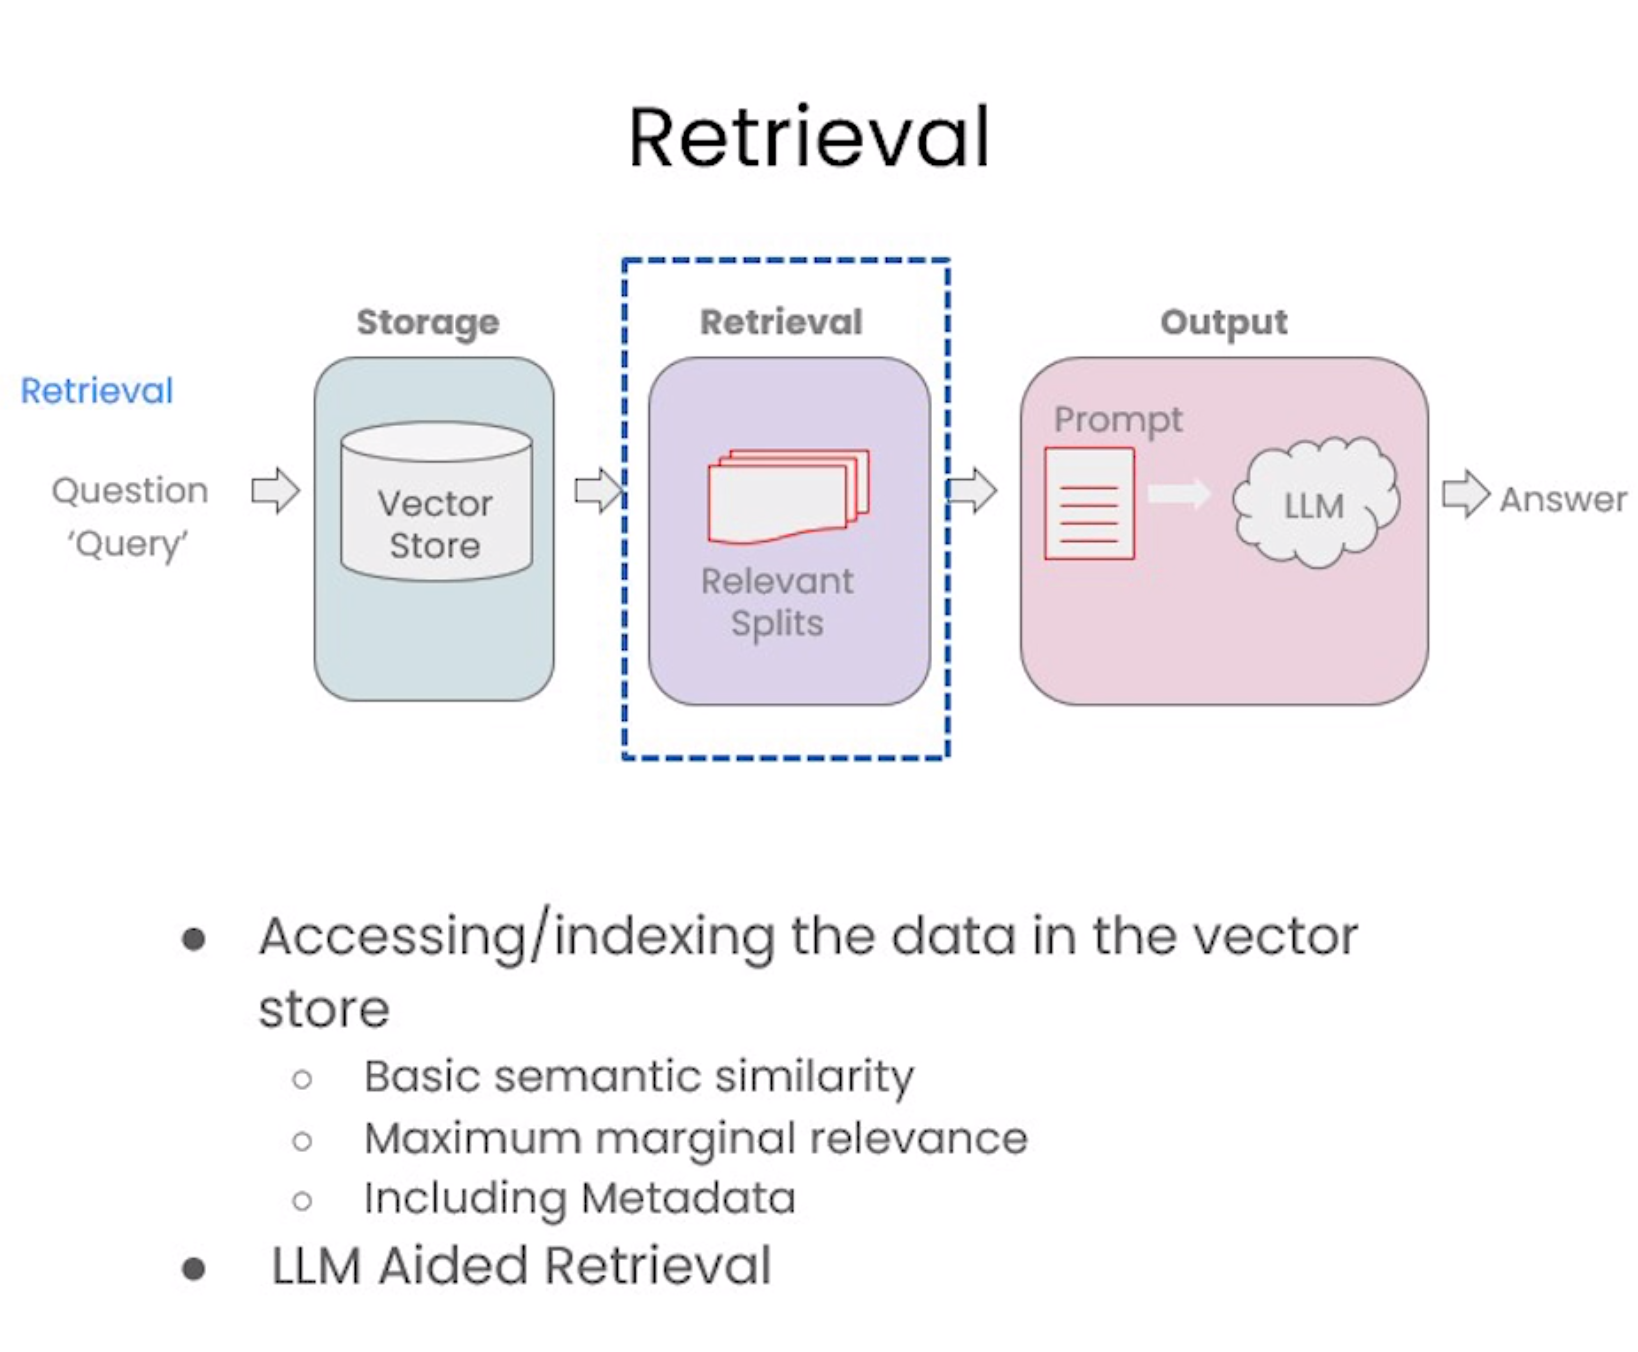

---

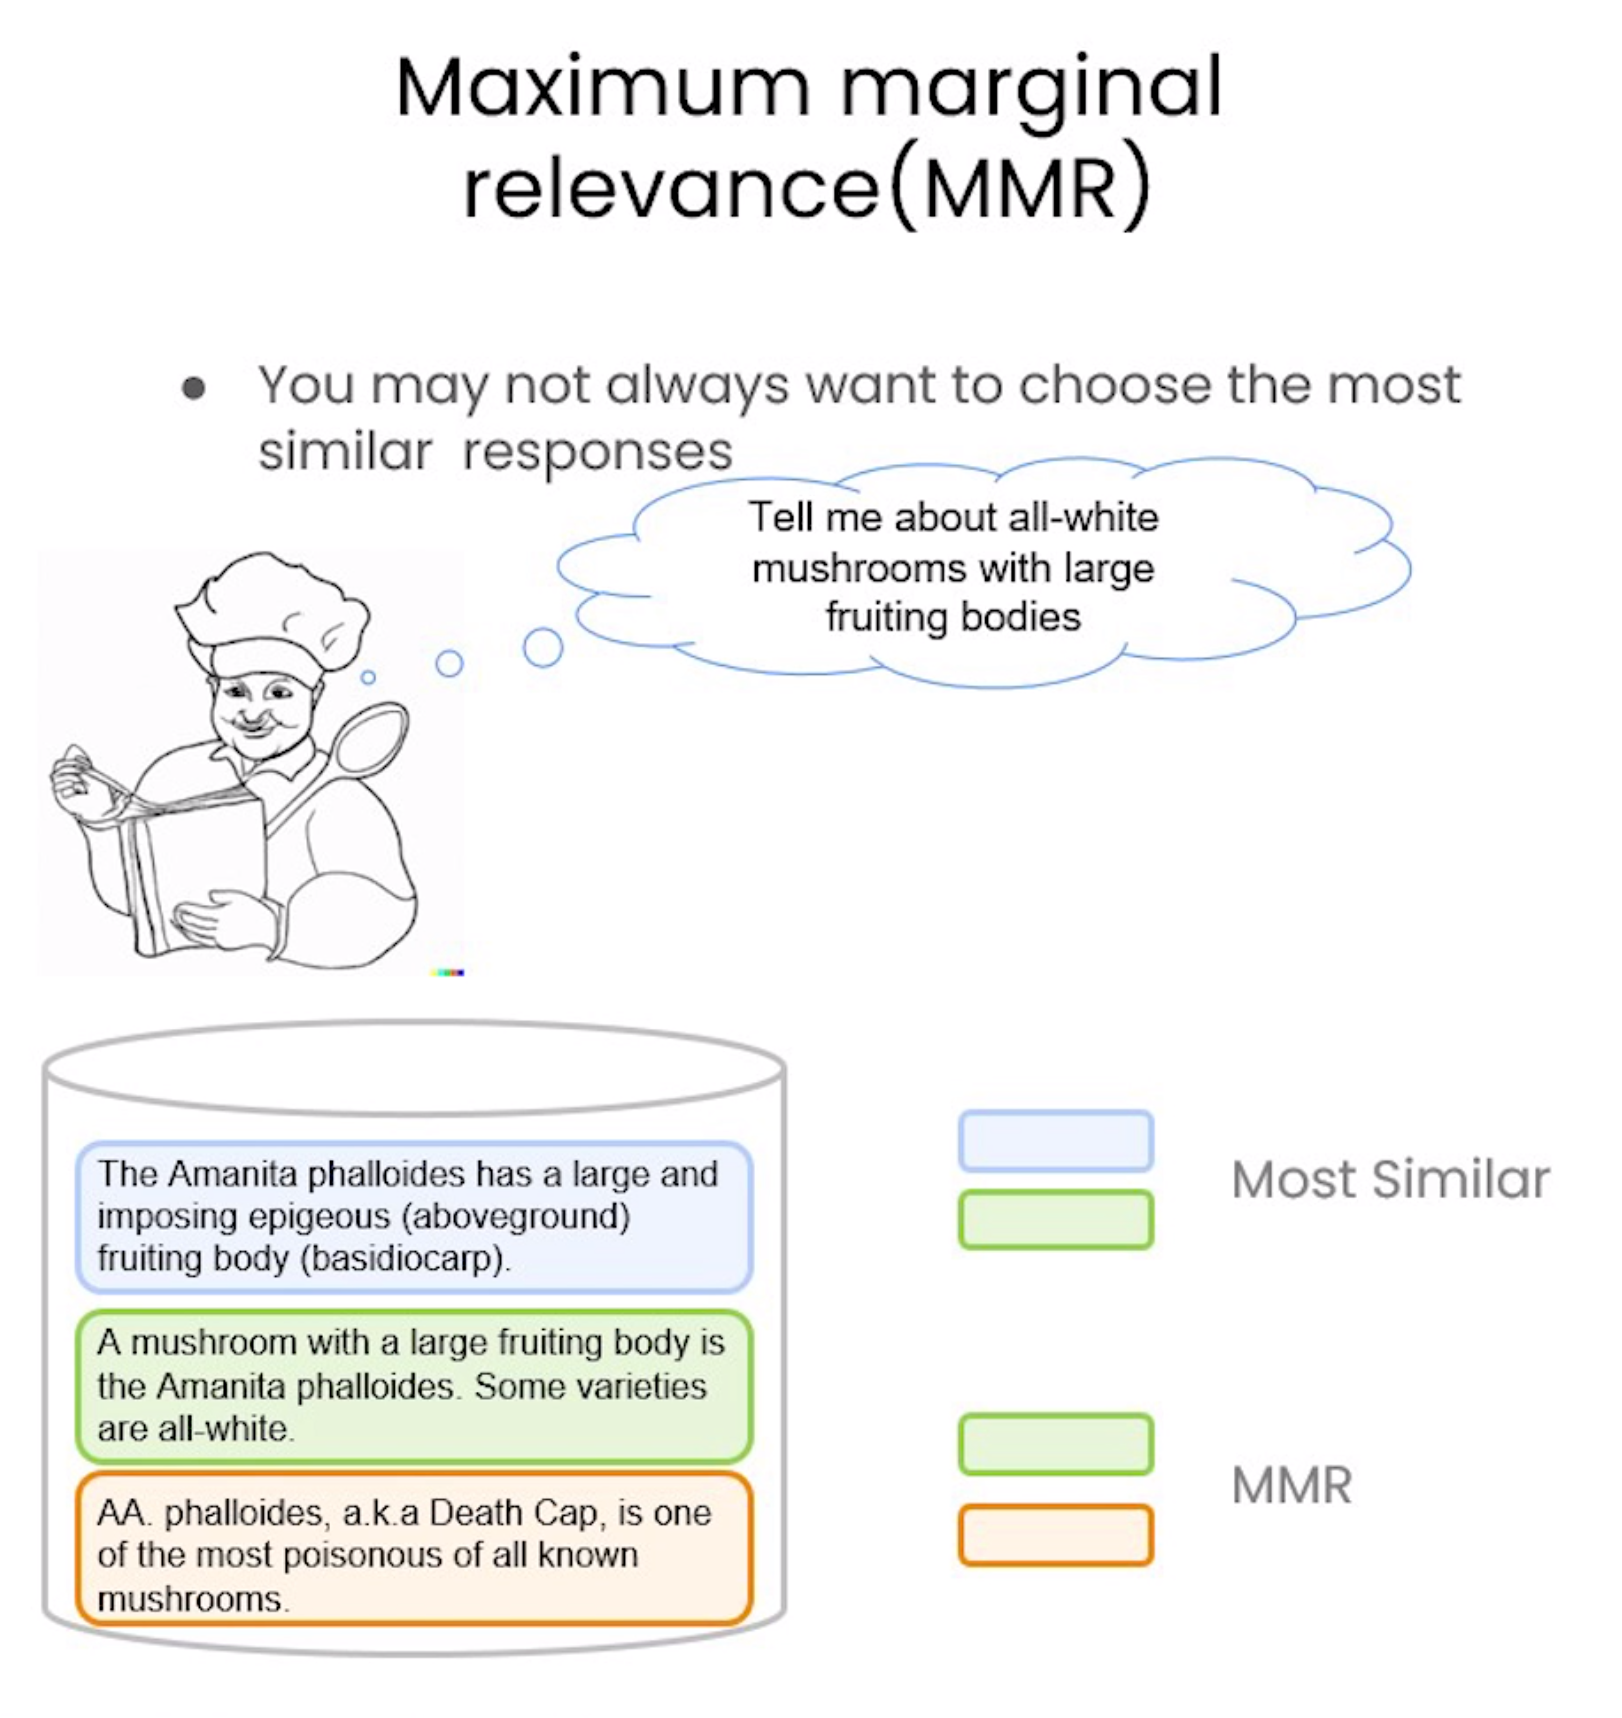

---

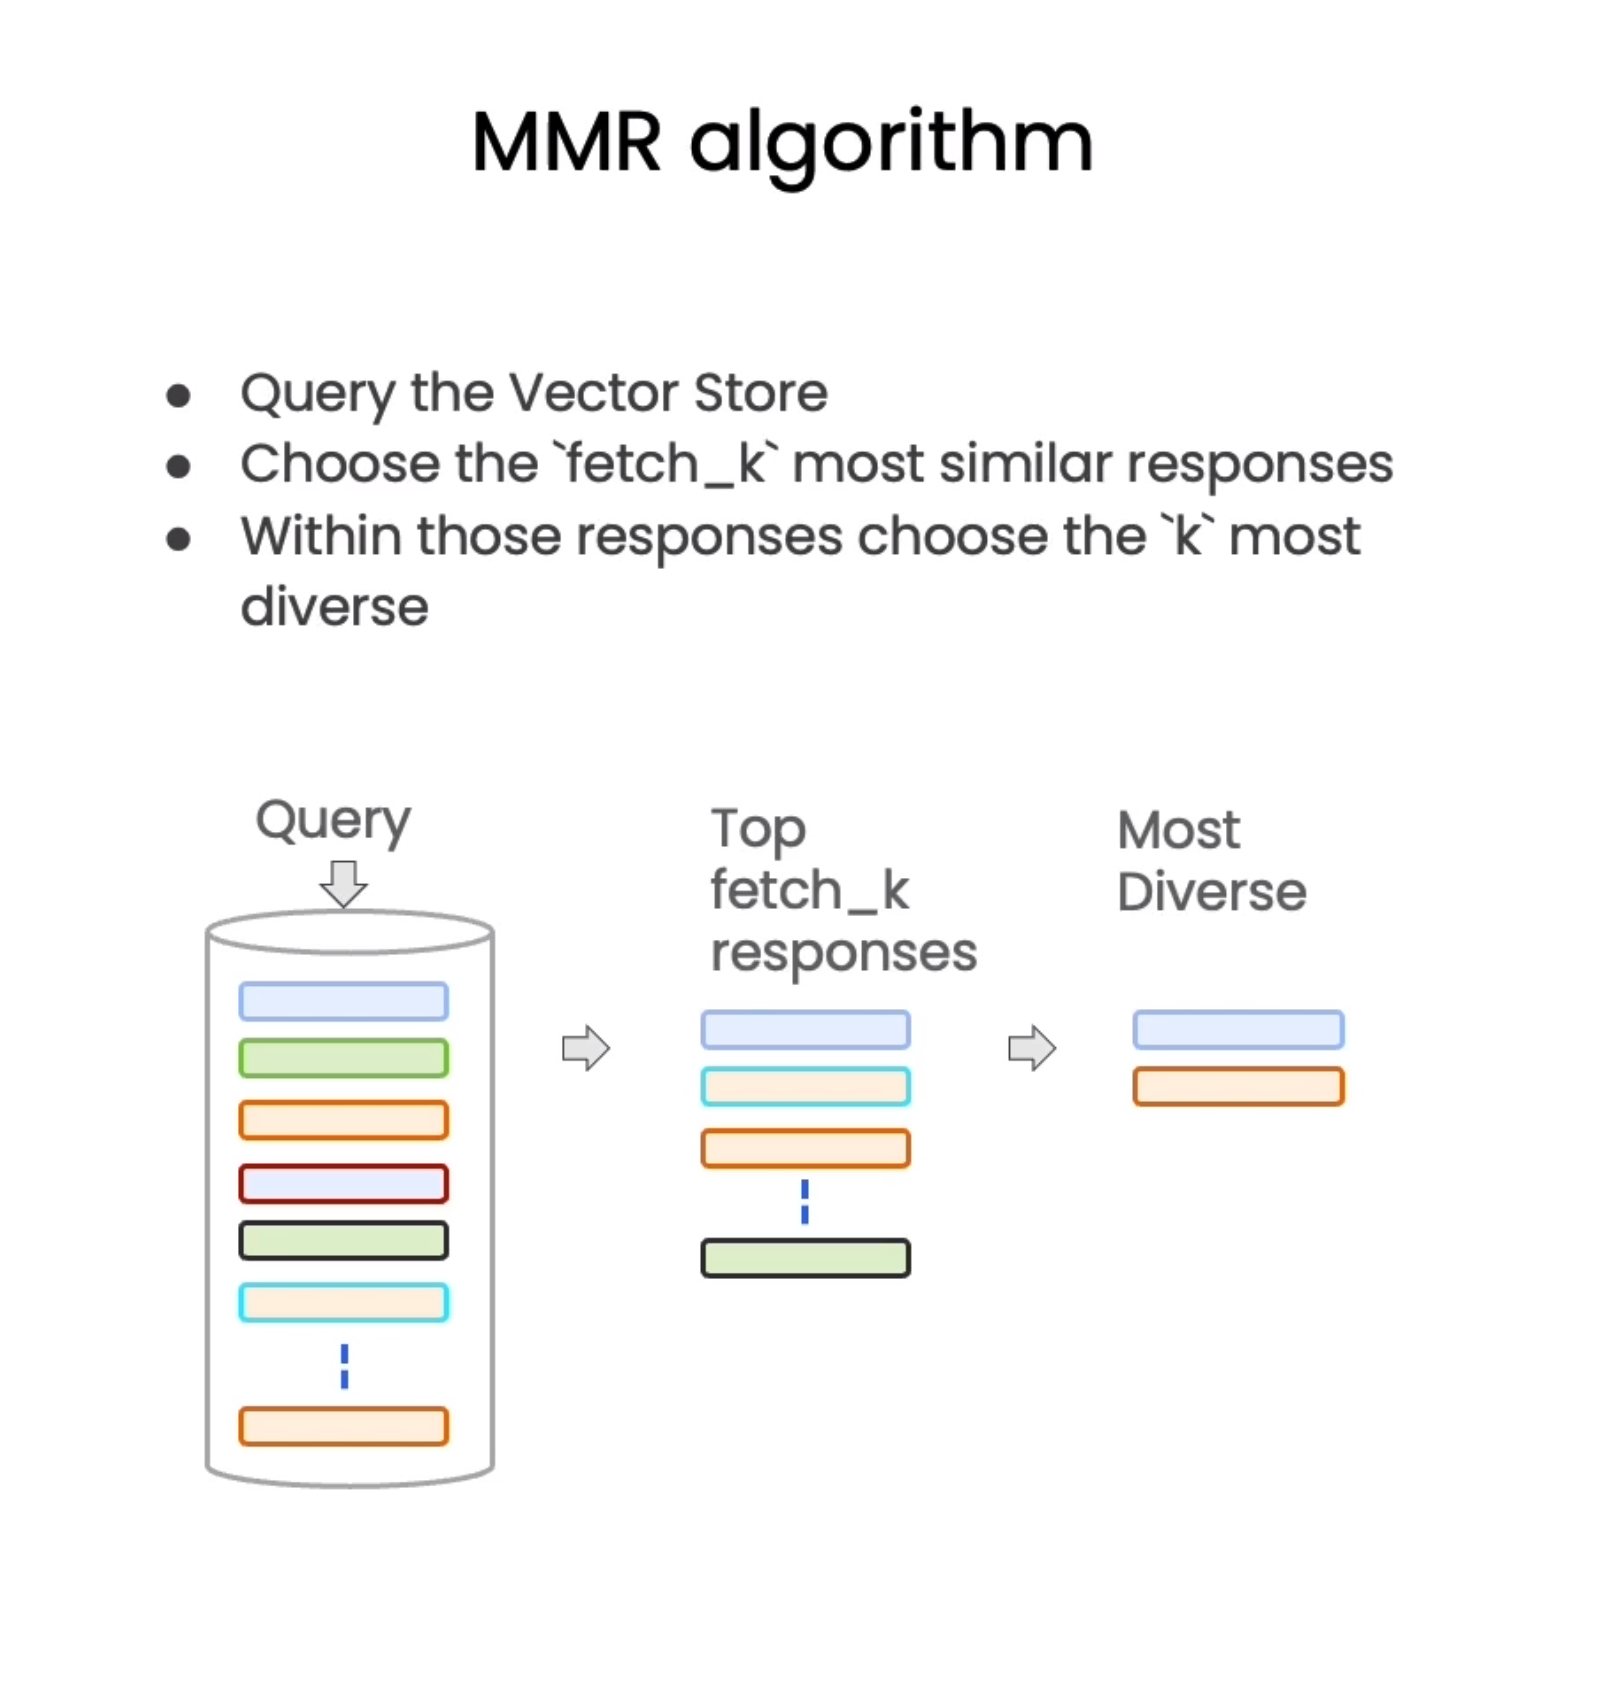
---

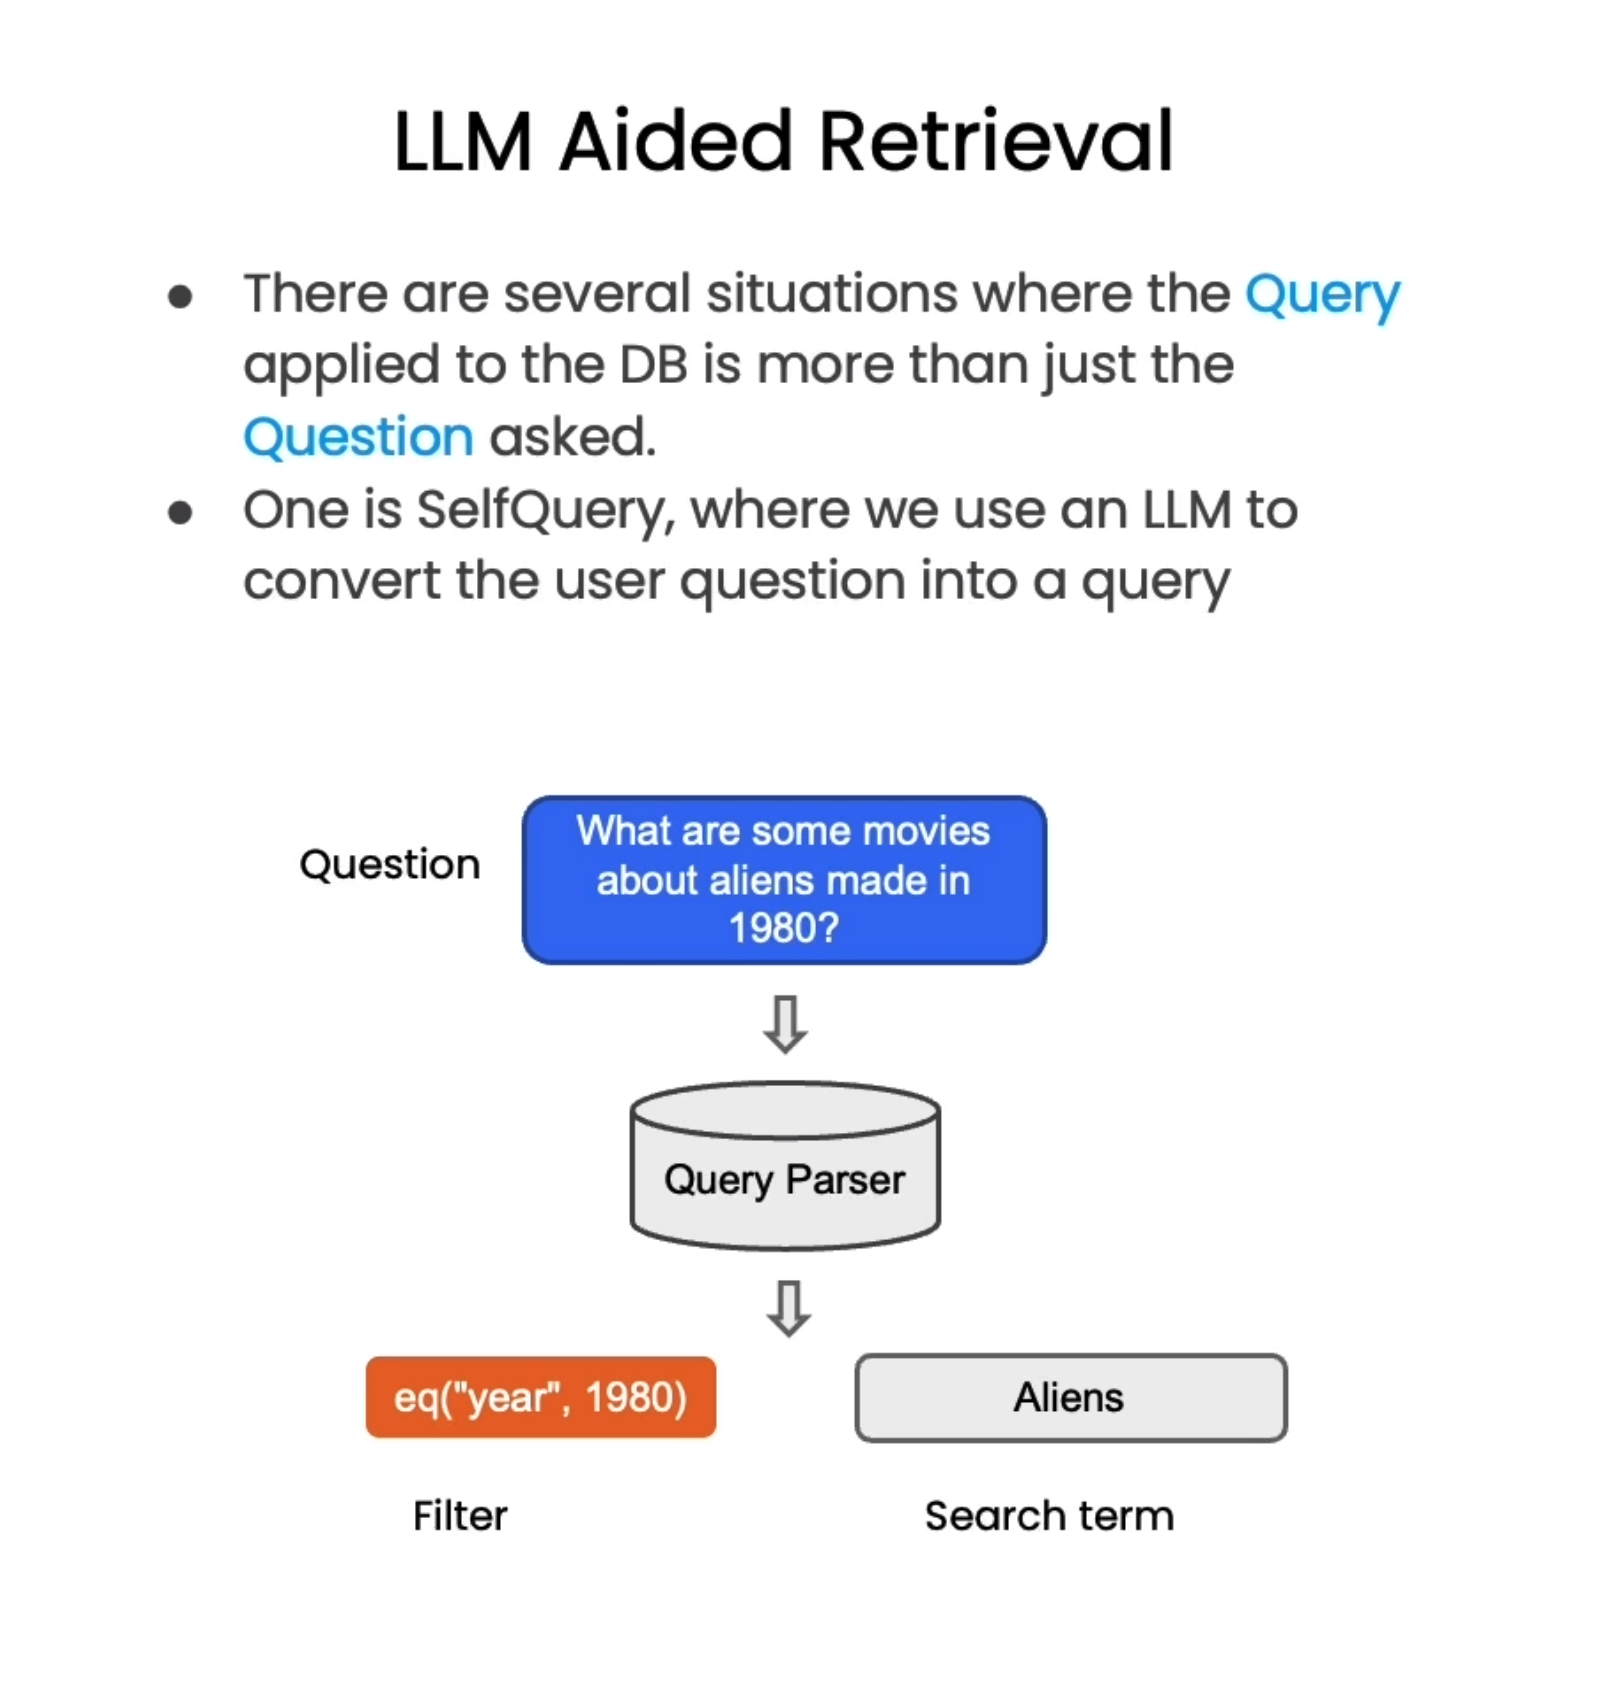

---

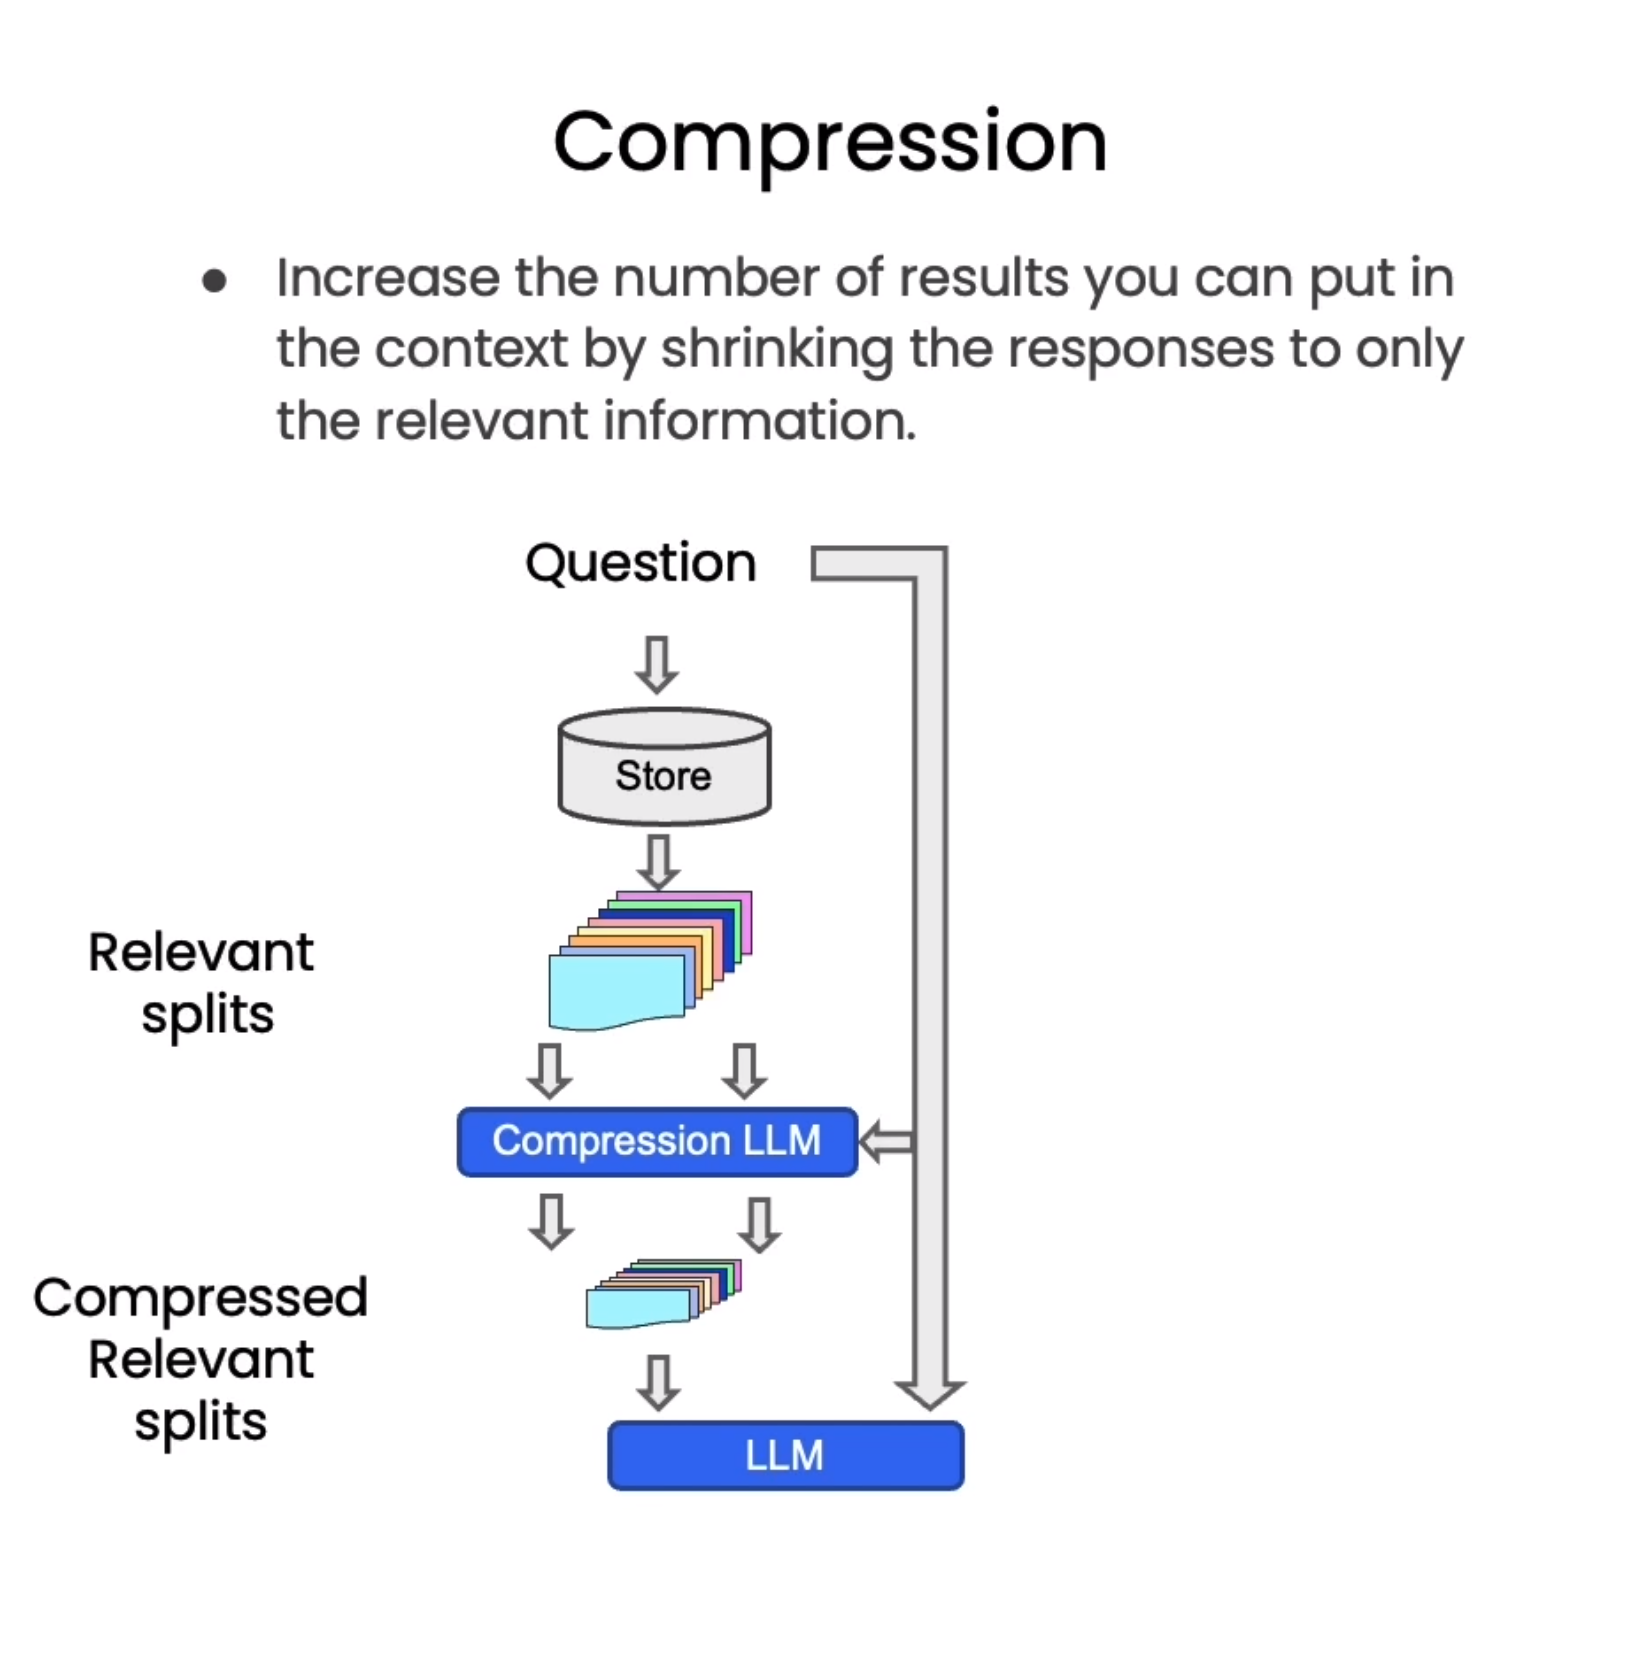

---

## Vectorstore retrieval


In [1]:
import os
import openai
import sys
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

In [2]:
#!pip install lark

### Similarity Search

In [3]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = 'docs/chroma/'

In [4]:
embedding = OpenAIEmbeddings()
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)

In [5]:
print(vectordb._collection.count())

209


In [6]:
texts = [
    """The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).""",
    """A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.""",
    """A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.""",
]

In [7]:
smalldb = Chroma.from_texts(texts, embedding=embedding)

In [8]:
question = "Tell me about all-white mushrooms with large fruiting bodies"

In [9]:
smalldb.similarity_search(question, k=2)

[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.', metadata={}),
 Document(page_content='The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).', metadata={})]

In [10]:
smalldb.max_marginal_relevance_search(question,k=2, fetch_k=3)

[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.', metadata={}),
 Document(page_content='A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.', metadata={})]

### Addressing Diversity: Maximum marginal relevance

Last class we introduced one problem: how to enforce diversity in the search results.
 
`Maximum marginal relevance` strives to achieve both relevance to the query *and diversity* among the results.

In [11]:
question = "what did they say about matlab?"
docs_ss = vectordb.similarity_search(question,k=3)

In [12]:
docs_ss[0].page_content[:100]

'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

In [13]:
docs_ss[1].page_content[:100]

'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

Note the difference in results with `MMR`.

In [14]:
docs_mmr = vectordb.max_marginal_relevance_search(question,k=3)

In [15]:
docs_mmr[0].page_content[:100]

'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

In [16]:
docs_mmr[1].page_content[:100]

'algorithm then? So what’s different? How come  I was making all that noise earlier about \nleast squa'

### Addressing Specificity: working with metadata

In last lecture, we showed that a question about the third lecture can include results from other lectures as well.

To address this, many vectorstores support operations on `metadata`.

`metadata` provides context for each embedded chunk.

In [17]:
question = "what did they say about regression in the third lecture?"

In [18]:
docs = vectordb.similarity_search(
    question,
    k=3,
    filter={"source":"docs/cs229_lectures/MachineLearning-Lecture03.pdf"}
)

In [19]:
for d in docs:
    print(d.metadata)

{'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf', 'page': 0}
{'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf', 'page': 14}
{'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf', 'page': 4}


### Addressing Specificity: working with metadata using self-query retriever

But we have an interesting challenge: we often want to infer the metadata from the query itself.

To address this, we can use `SelfQueryRetriever`, which uses an LLM to extract:
 
1. The `query` string to use for vector search
2. A metadata filter to pass in as well

Most vector databases support metadata filters, so this doesn't require any new databases or indexes.

In [20]:
from langchain.llms import OpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [21]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The lecture the chunk is from, should be one of `docs/cs229_lectures/MachineLearning-Lecture01.pdf`, `docs/cs229_lectures/MachineLearning-Lecture02.pdf`, or `docs/cs229_lectures/MachineLearning-Lecture03.pdf`",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the lecture",
        type="integer",
    ),
]

**Note:** The default model for `OpenAI` ("from langchain.llms import OpenAI") is `text-davinci-003`. Due to the deprication of OpenAI's model `text-davinci-003` on 4 January 2024, you'll be using OpenAI's recommended replacement model `gpt-3.5-turbo-instruct` instead.

In [22]:
document_content_description = "Lecture notes"
llm = OpenAI(model='gpt-3.5-turbo-instruct', temperature=0)
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectordb,
    document_content_description,
    metadata_field_info,
    verbose=True
)

In [23]:
question = "what did they say about regression in the third lecture?"

**You will receive a warning** about predict_and_parse being deprecated the first time you executing the next line. This can be safely ignored.

In [24]:
docs = retriever.get_relevant_documents(question)

/usr/local/lib/python3.9/site-packages/langchain/chains/llm.py:275: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


query='regression' filter=Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='source', value='docs/cs229_lectures/MachineLearning-Lecture03.pdf') limit=None


In [25]:
for d in docs:
    print(d.metadata)

{'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf', 'page': 14}
{'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf', 'page': 0}
{'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf', 'page': 10}
{'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf', 'page': 10}


### Additional tricks: compression

Another approach for improving the quality of retrieved docs is compression.

Information most relevant to a query may be buried in a document with a lot of irrelevant text. 

Passing that full document through your application can lead to more expensive LLM calls and poorer responses.

Contextual compression is meant to fix this. 

In [26]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

In [27]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))


In [28]:
# Wrap our vectorstore
llm = OpenAI(temperature=0)
compressor = LLMChainExtractor.from_llm(llm)

In [29]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

In [30]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

Document 1:

"MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to plot data. And it's sort of an extremely easy to learn tool to use for implementing a lot of learning algorithms."
----------------------------------------------------------------------------------------------------
Document 2:

"MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to plot data. And it's sort of an extremely easy to learn tool to use for implementing a lot of learning algorithms."
----------------------------------------------------------------------------------------------------
Document 3:

"And the student said, "Oh, it was the MATLAB." So for those of you that don't know MATLAB yet, I hope you do learn it. It's not hard, and we'll actually have a short MATLAB tutorial in one o

## Combining various techniques

In [31]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever(search_type = "mmr")
)

In [32]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

Document 1:

"MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to plot data. And it's sort of an extremely easy to learn tool to use for implementing a lot of learning algorithms."
----------------------------------------------------------------------------------------------------
Document 2:

"And the student said, "Oh, it was the MATLAB." So for those of you that don't know MATLAB yet, I hope you do learn it. It's not hard, and we'll actually have a short MATLAB tutorial in one of the discussion sections for those of you that don't know it."


## Other types of retrieval

It's worth noting that vectordb as not the only kind of tool to retrieve documents. 

The `LangChain` retriever abstraction includes other ways to retrieve documents, such as TF-IDF or SVM.

In [33]:
from langchain.retrievers import SVMRetriever
from langchain.retrievers import TFIDFRetriever
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [34]:
# Load PDF
loader = PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture01.pdf")
pages = loader.load()
all_page_text=[p.page_content for p in pages]
joined_page_text=" ".join(all_page_text)

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1500,chunk_overlap = 150)
splits = text_splitter.split_text(joined_page_text)


In [35]:
# Retrieve
svm_retriever = SVMRetriever.from_texts(splits,embedding)
tfidf_retriever = TFIDFRetriever.from_texts(splits)

In [36]:
question = "What are major topics for this class?"
docs_svm=svm_retriever.get_relevant_documents(question)
docs_svm[0]

/usr/local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Document(page_content="let me just check what questions you have righ t now. So if there are no questions, I'll just \nclose with two reminders, which are after class today or as you start to talk with other \npeople in this class, I just encourage you again to start to form project partners, to try to \nfind project partners to do your project with. And also, this is a good time to start forming \nstudy groups, so either talk to your friends  or post in the newsgroup, but we just \nencourage you to try to star t to do both of those today, okay? Form study groups, and try \nto find two other project partners.  \nSo thank you. I'm looking forward to teaching this class, and I'll see you in a couple of \ndays.   [End of Audio]  \nDuration: 69 minutes", metadata={})

In [37]:
question = "what did they say about matlab?"
docs_tfidf=tfidf_retriever.get_relevant_documents(question)
docs_tfidf[0]

Document(page_content="Saxena and Min Sun here did, wh ich is given an image like this, right? This is actually a \npicture taken of the Stanford campus. You can apply that sort of cl ustering algorithm and \ngroup the picture into regions. Let me actually blow that up so that you can see it more \nclearly. Okay. So in the middle, you see the lines sort of groupi ng the image together, \ngrouping the image into [inaudible] regions.  \nAnd what Ashutosh and Min did was they then  applied the learning algorithm to say can \nwe take this clustering and us e it to build a 3D model of the world? And so using the \nclustering, they then had a lear ning algorithm try to learn what the 3D structure of the \nworld looks like so that they could come up with a 3D model that you can sort of fly \nthrough, okay? Although many people used to th ink it's not possible to take a single \nimage and build a 3D model, but using a lear ning algorithm and that sort of clustering \nalgorithm is the first ste